In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras.optimizers import Nadam
import math
import matplotlib.pyplot as plt

D:\installed\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def readDataset(filename):
    text_file = open(filename, 'r')
    dataset = []   
    for line in text_file:  
        line = line.split(',')      
        dt = [ float(x) for x in line ]
        dataset.append(dt)    
    text_file.close()
    dataset = np.array(dataset)
    return dataset
def tagData(data,perc):
    sz = math.ceil(data.shape[0]*perc/100)
    dat = np.zeros((data.shape[0],data.shape[1]*2))
    dat[:data.shape[0],:data.shape[1]] =data  #append column for labels
    dat[:data.shape[0]-1,data.shape[1]:] =data[1:,:]  #append column for labels   
    
    xtrain = dat[:sz,:4]    
    ytrain = dat[:sz,4:]
    
    xtest = dat[sz-1:,:4]
    ytest = dat[sz-1:,4:]
        
    xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
    xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))
    
    return xtrain, ytrain,xtest,ytest

In [4]:
epoch = 125
percentage = 60

In [118]:

file = 'EURUSDmicro_ H4_CandleData.txt'
data = readDataset(file)

xtrain, ytrain,xtest,ytest = tagData(data,percentage)
print('training samples: ',xtrain.shape)
print('testing samples: ',xtest.shape)

training samples:  (6047, 1, 4)
testing samples:  (4031, 1, 4)


In [119]:
cand = Sequential()
cand.add(LSTM(250, input_shape=(xtrain.shape[1], xtrain.shape[2])))
cand.add(Dense(4))

In [120]:
def FLF(yTrue,yPred):
    import tensorflow as tf
    from keras import backend as K
    from keras.layers import Lambda
    lam = 0.1   
    v = Lambda(lambda x: x*0.9)((yTrue-yPred)) 
    vn = Lambda(lambda x: x*lam)(K.abs((yTrue[:,1]+yTrue[:,2])/2 - (yPred[:,1]+yPred[:,2])/2))
    vn1 = Lambda(lambda x: x*lam)(K.abs((yTrue[:,0]+yTrue[:,3])/2 - (yPred[:,0]+yPred[:,3])/2))
    vx = K.square((v[:,0]-vn1))
    vy = K.square((v[:,1]-vn))
    vz = K.square((v[:,2]-vn))    
    v4 = K.square((v[:,3]-vn1))
    
    vm = K.concatenate([vx,vy,vz,v4])
    vmx = K.mean(vm)
    
    return vmx

In [121]:
opt = Nadam(lr=0.00001, beta_1=0.09, beta_2=0.0999, epsilon=None, schedule_decay=0.0004)


cand.compile(loss=FLF, optimizer=opt)#'Nadam'
cand_history = cand.fit(xtrain, ytrain, epochs=epoch, batch_size=72, validation_data=(xtest, ytest), verbose=1, shuffle=True)


Train on 6047 samples, validate on 4031 samples
Epoch 1/125
6047/6047 [==============================] - 6s 1ms/step - loss: 0.9902 - val_loss: 0.8035
Epoch 2/125
6047/6047 [==============================] - 2s 348us/step - loss: 0.9614 - val_loss: 0.7796
Epoch 3/125
6047/6047 [==============================] - 2s 315us/step - loss: 0.9329 - val_loss: 0.7561
Epoch 4/125
6047/6047 [==============================] - 2s 304us/step - loss: 0.9050 - val_loss: 0.7329
Epoch 5/125
6047/6047 [==============================] - 2s 321us/step - loss: 0.8773 - val_loss: 0.7099
Epoch 6/125
6047/6047 [==============================] - 2s 301us/step - loss: 0.8500 - val_loss: 0.6872
Epoch 7/125
6047/6047 [==============================] - 2s 293us/step - loss: 0.8228 - val_loss: 0.6646
Epoch 8/125
6047/6047 [==============================] - 2s 291us/step - loss: 0.7959 - val_loss: 0.6422
Epoch 9/125
6047/6047 [==============================] - 2s 290us/step - loss: 0.7690 - val_loss: 0.6199
Epoch 10/

Epoch 76/125
6047/6047 [==============================] - 2s 313us/step - loss: 1.7816e-05 - val_loss: 3.6350e-04
Epoch 77/125
6047/6047 [==============================] - 2s 315us/step - loss: 1.6248e-05 - val_loss: 3.5732e-04
Epoch 78/125
6047/6047 [==============================] - 2s 291us/step - loss: 1.4982e-05 - val_loss: 3.5717e-04
Epoch 79/125
6047/6047 [==============================] - 2s 321us/step - loss: 1.3885e-05 - val_loss: 3.6341e-04
Epoch 80/125
6047/6047 [==============================] - 2s 294us/step - loss: 1.2786e-05 - val_loss: 3.5619e-04
Epoch 81/125
6047/6047 [==============================] - 2s 314us/step - loss: 1.1728e-05 - val_loss: 3.5896e-04
Epoch 82/125
6047/6047 [==============================] - 2s 288us/step - loss: 1.0800e-05 - val_loss: 3.5624e-04
Epoch 83/125
6047/6047 [==============================] - 2s 312us/step - loss: 1.0061e-05 - val_loss: 3.5381e-04
Epoch 84/125
6047/6047 [==============================] - 3s 450us/step - loss: 9.2289e-

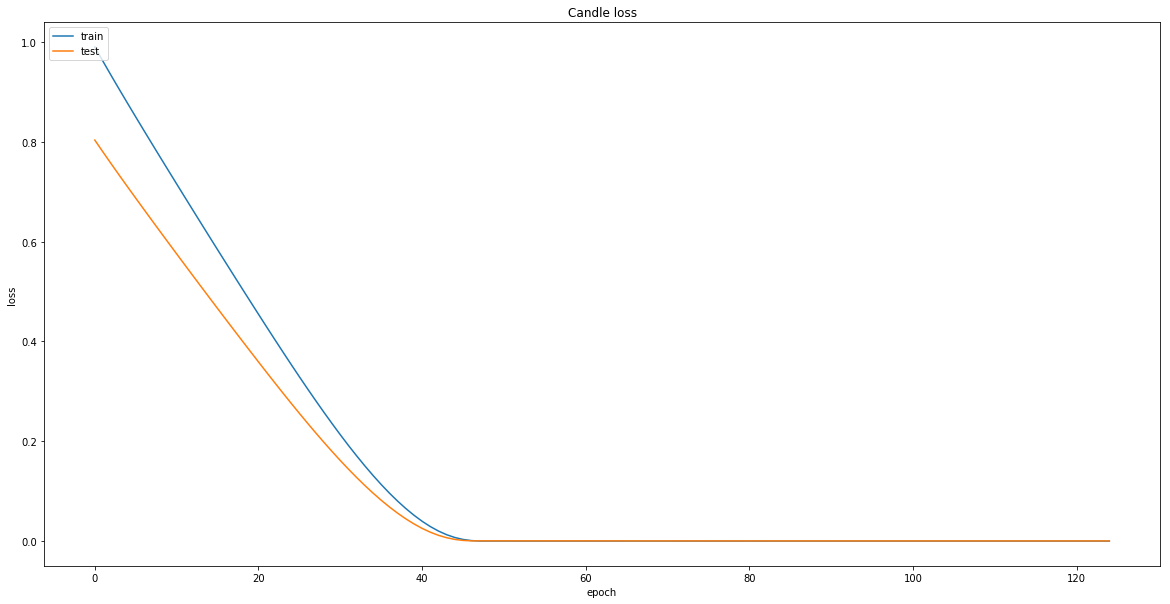

In [122]:
plt.figure(figsize=(20,10))
plt.plot(cand_history.history['loss'])
plt.plot(cand_history.history['val_loss'])
plt.title('Candle loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [123]:
# input: [1.16066000,1.16242000,1.15877000,1.16092000]
# output: [1.16089000,1.16100000,1.15628000,1.15677000]



n = np.array([1.16066000,1.16242000,1.15877000,1.16092000])
n = n.reshape((1, 1, 4))
print('predicted candle',cand.predict(n))
#[[1.1606843 1.1630912 1.1585828 1.1606563]] lamda = 0.0001
#lamda = 0.001 is worst
#[[1.1599967 1.1624613 1.1579314 1.1600161]] lamda = 0.00001 (length is little worst)
#without v1*lamda [[1.15988   1.16225   1.1578116 1.1598842]]
#with v1*lamda [[1.1601095 1.1623019 1.1580093 1.1603234]]
#with v1*lamda/2 [[1.1606686 1.1632429 1.1586095 1.1612281]]

predicted candle [[1.1597805 1.1622036 1.1577373 1.1598929]]


In [124]:
print('predicting candles')
prediCand = cand.predict(xtest)
print(prediCand.shape)

predicting candles
(4031, 4)


In [125]:
prediOpen = prediCand[:,0]
prediHigh = prediCand[:,1]
prediLow = prediCand[:,2]
prediClose = prediCand[:,3]

actOpen = ytest[:,0]
actHigh = ytest[:,1]
actLow = ytest[:,2]
actClose = ytest[:,3]

In [126]:
fn = 'data\open_LSTM_FLF.txt'
text_file = open(fn, 'w')
#dataset = []   
for line in prediOpen:
    s = str(line) + '\n'    
    text_file.write(s)      
text_file.close()



fn = 'data\high_LSTM_FLF.txt'
text_file = open(fn, 'w')
#dataset = []   
for line in prediHigh:
    s = str(line) + '\n'    
    text_file.write(s)      
text_file.close()


fn = 'data\low_LSTM_FLF.txt'
text_file = open(fn, 'w')
#dataset = []   
for line in prediLow:
    s = str(line) + '\n'    
    text_file.write(s)       
text_file.close()


fn = 'data\close_LSTM_FLF.txt'
text_file = open(fn, 'w')
#dataset = []   
for line in prediClose:
    s = str(line) + '\n'    
    text_file.write(s)      
text_file.close()

In [115]:
modelFolder = 'Models\\'
cand.save(modelFolder+'FLF_lamda=0.0001.h5')


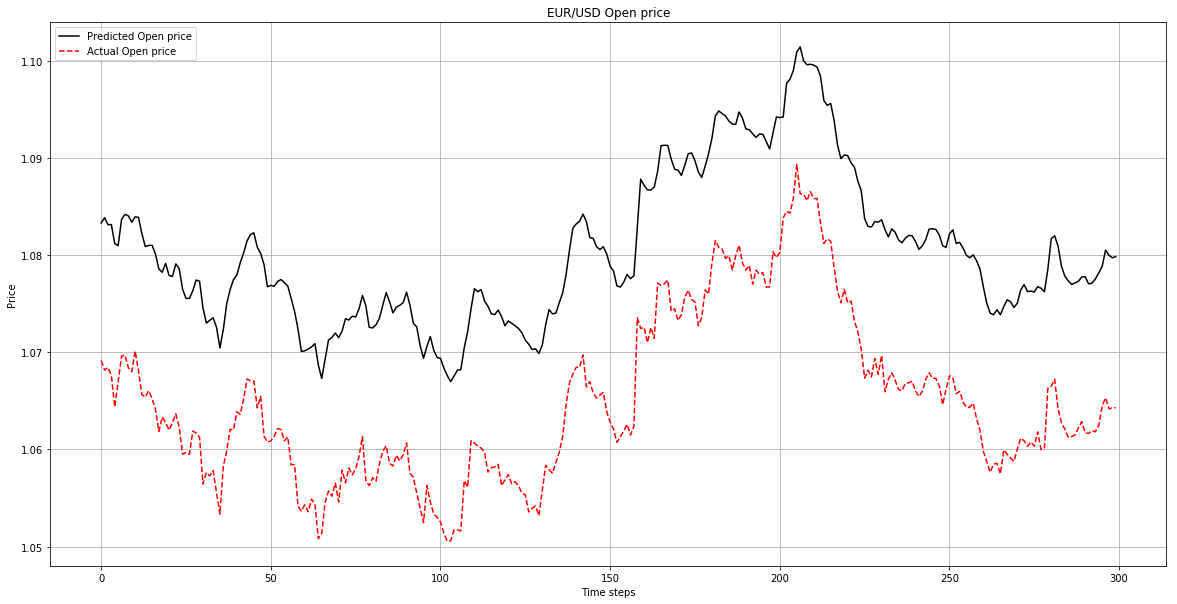

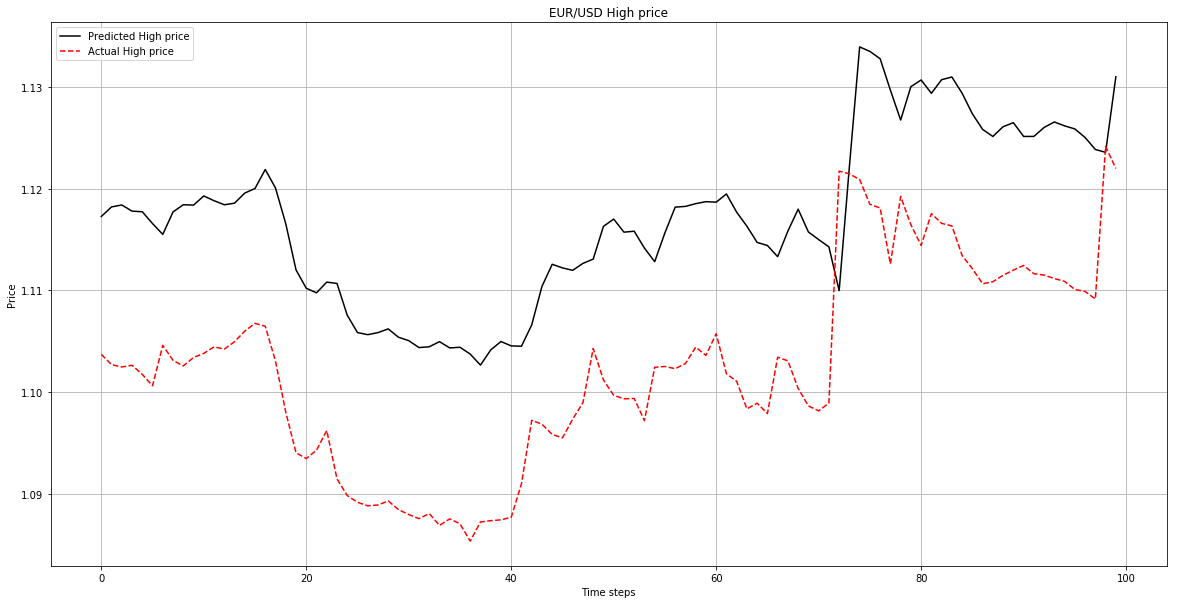

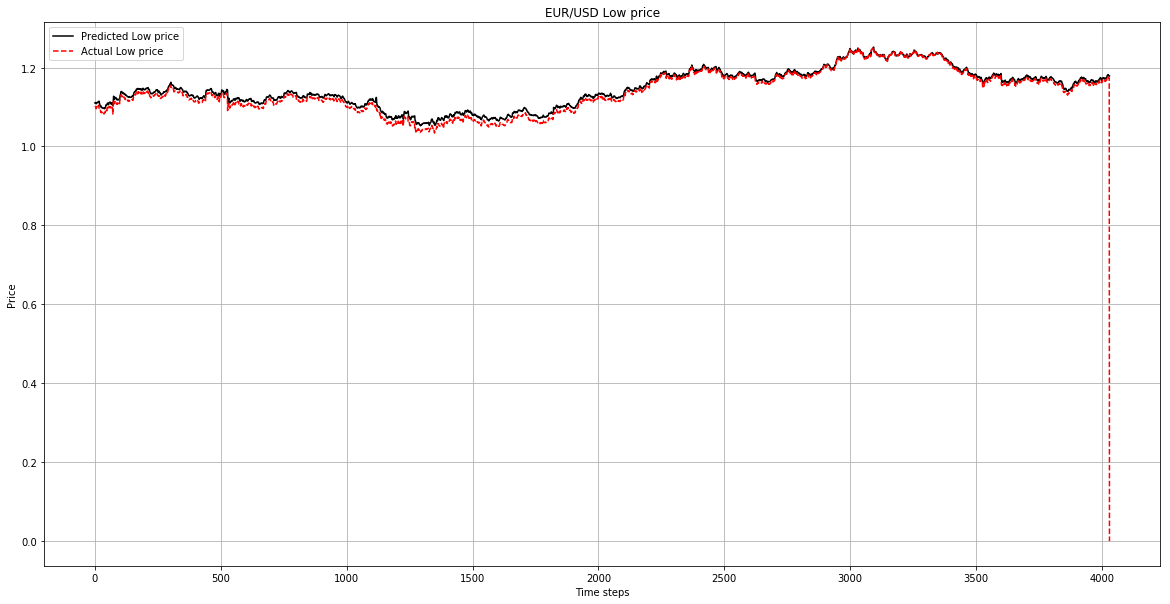

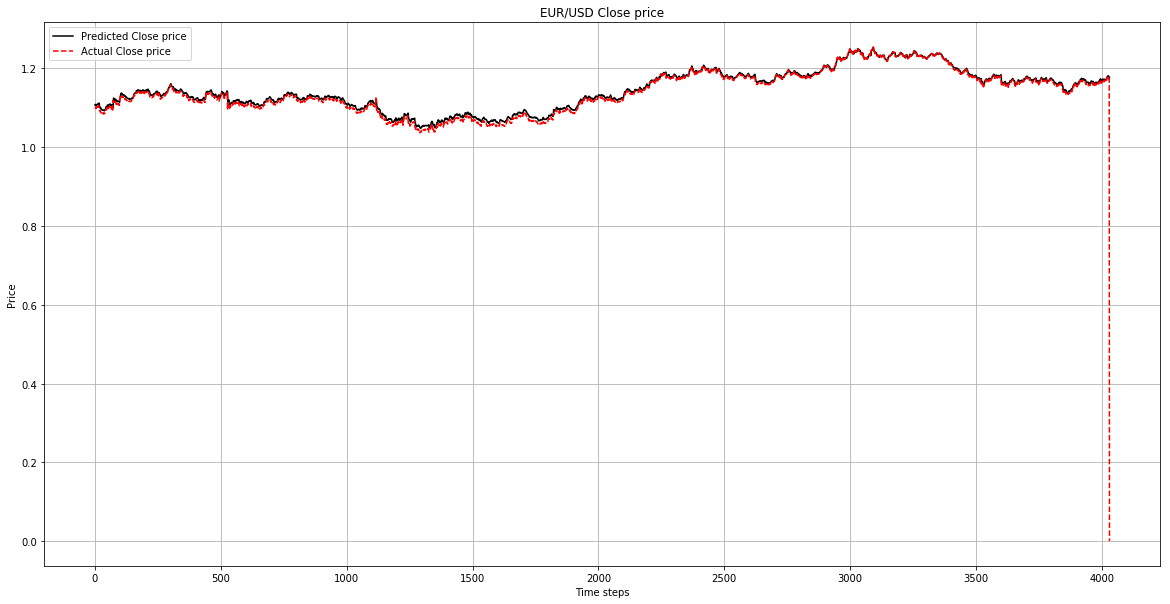

In [107]:
plt.figure(figsize=(20,10))
plt.plot(range(300), prediOpen[1500:1800],'k-', label = 'Predicted Open price');
plt.plot(range(300),actOpen[1500:1800],'r--', label = 'Actual Open price')
plt.xlabel('Time steps')
plt.ylabel('Price')
plt.title('EUR/USD Open price')
plt.grid(True)
plt.legend(loc = 'upper left')
            
plt.figure(figsize=(20,10))
plt.plot(range(100), prediHigh[:100],'k-', label = 'Predicted High price');
plt.plot(range(100),actHigh[:100],'r--', label = 'Actual High price')
plt.xlabel('Time steps')
plt.ylabel('Price')
plt.title('EUR/USD High price')
plt.grid(True)
plt.legend(loc = 'upper left')
            
plt.figure(figsize=(20,10))
plt.plot(range(prediLow.shape[0]), prediLow,'k-', label = 'Predicted Low price');
plt.plot(range(prediLow.shape[0]),actLow,'r--', label = 'Actual Low price')
plt.xlabel('Time steps')
plt.ylabel('Price')
plt.title('EUR/USD Low price')
plt.grid(True)
plt.legend(loc = 'upper left')
            
plt.figure(figsize=(20,10))
plt.plot(range(prediLow.shape[0]), prediClose,'k-', label = 'Predicted Close price');
plt.plot(range(prediLow.shape[0]),actClose,'r--', label = 'Actual Close price')
plt.xlabel('Time steps')
plt.ylabel('Price')
plt.title('EUR/USD Close price')
plt.grid(True)
plt.legend(loc = 'upper left')